# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [ ]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/ckurtz/cs294-158-ssl
!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 611 (delta 115), reused 119 (delta 53), pack-reused 422 (from 1)
Receiving objects: 100% (611/611), 3.11 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul_helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25300 sha256=f29af229378d4fa114cae7d773d2c2ec0b229dec402c07cf487edde689b09273
  Stored in directory: /root/.cache/pip/wheels/e3/df/97/281e32d717214451862e0e558746de423b9ef530b7376421e2
Successfully built deepul_helper


Run the cells below to download the necessary pretrained models. It should take a few minutes.

In [ ]:
!wget https://camille-kurtz.com/teaching/data.zip
!unzip -qq data.zip
!rm data.zip

--2024-11-02 14:28:48--  https://camille-kurtz.com/teaching/data.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4227668031 (3.9G) [application/zip]
Saving to: ‘data.zip’

data.zip              4%[                    ] 198.21M  28.5MB/s    eta 2m 38s ^C
[data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.


In [ ]:
!wget https://camille-kurtz.com/teaching/results.zip
!unzip -qq results.zip
!rm results.zip

--2024-11-02 14:29:00--  https://camille-kurtz.com/teaching/results.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636425194 (2.5G) [application/zip]
Saving to: ‘results.zip’

results.zip         100%[===================>]   2.46G  29.5MB/s    in 89s     

2024-11-02 14:30:29 (28.4 MB/s) - ‘results.zip’ saved [2636425194/2636425194]



The models and demos shown were pre-trained. The code used for all the demos can be found in the github repo [here](https://github.com/wilson1yan/cs294-158-ssl). Follow the README to train models on CIFAR10 or ImageNet.

# Self-Supervised Learning Tasks
Self-supervised learning is a rapidly growing field, its success largely accelerated by growing compute and the vast amount of unlabeled data available for training. The hope is that by pretraining on specially designed self-supervised tasks, the models would be able to learn semantically meaningful representations to be used for downstream tasks. In the following demos, we will look at a few examples of these self-supervised tasks.

In [ ]:
from deepul_helper.demos import load_model_and_data, evaluate_accuracy, display_nearest_neighbors, show_context_encoder_inpainting,evaluate_classifier

%matplotlib inline

## Demo 1: Context Encoder [[1]](https://arxiv.org/abs/1604.07379)

The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$
However, this demo does not use the adversarial portion of the loss.

### Example Code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes):
        super().__init__()
        input_channels = 3

        self.latent_dim = 4000

        # Encodes the masked image 6x (Conv->Norm->RelU)
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        # 5x(Norm->RelU->ConvT)
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon


### Inpainting Examples
For each pair of images, the left image is the masked input and the right the inpainted reconstruction.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/content/cs294-158-ssl/deepul_helper/demos.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickli

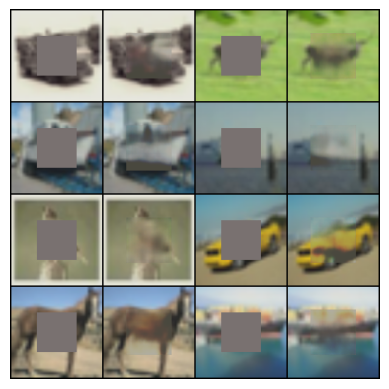

In [ ]:
show_context_encoder_inpainting()

### Linear Classification
By design the model architecture is an encoder -> decoder module. We can use the bottleneck layer as our learned representation. Below, we show linear classification accuracy results on CIFAR10 using the learned representations.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


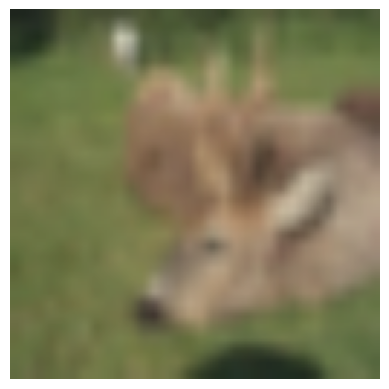

Top 16 Nearest Neighbors (in latent space)


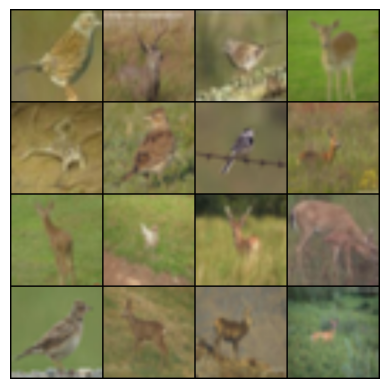

Image 2


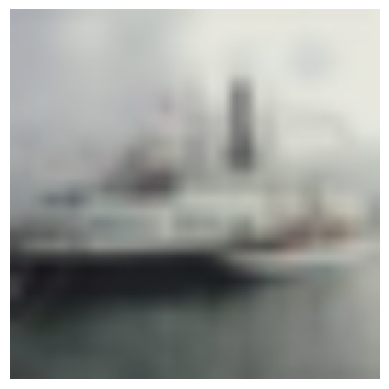

Top 16 Nearest Neighbors (in latent space)


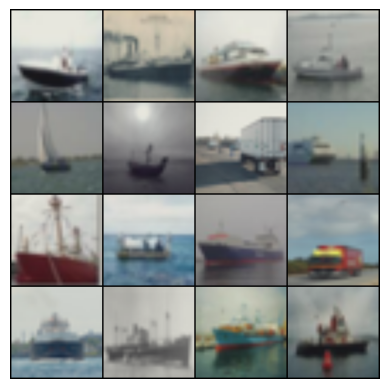

Image 3


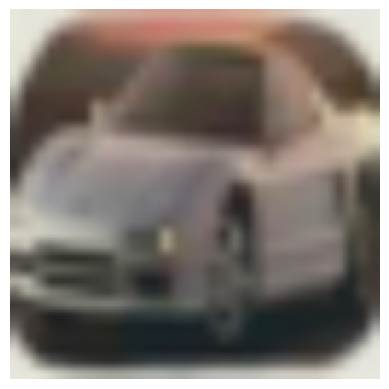

Top 16 Nearest Neighbors (in latent space)


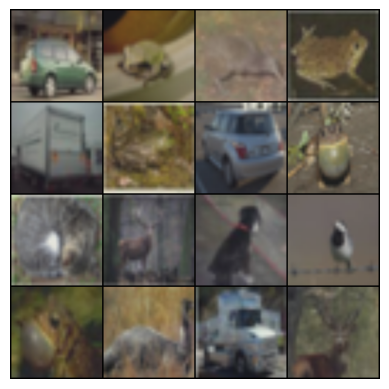

Image 4


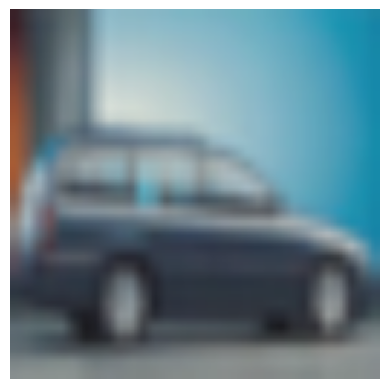

Top 16 Nearest Neighbors (in latent space)


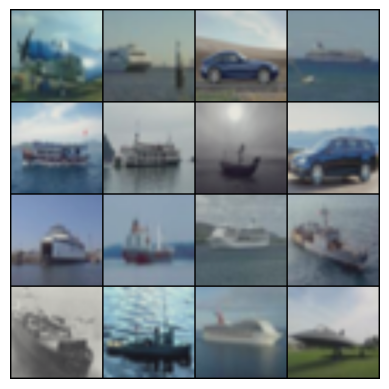

In [ ]:
display_nearest_neighbors('context_encoder', model, test_loader)

## Demo 2: Rotation Prediction [[2]](https://arxiv.org/abs/1803.07728)

In this paper, the authors show that accurately predicting the degrees of rotation in images is a self-supervised learning task that learns good representations for downstream tasks.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

More specifically, the authors showed that training a common CNN architecture (AlexNet, ResNet) on the rotation task learns semantically interpretable convolutional masks similar to those learned in supervised learning.

### Example Code

In [ ]:
import math
from deepul_helper.tasks.rotation import NetworkInNetwork, AlexNet

import torch
import torch.nn as nn
import torch.nn.functional as F


class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, dataset, n_classes):
        super().__init__()
        if dataset == 'cifar10' or dataset == "fashionmnist":
            self.model = NetworkInNetwork()
            self.latent_dim = 192 * 8 * 8
            self.feat_layer = 'conv2'
        elif 'imagenet' in dataset:
            self.model = AlexNet()
            self.latent_dim = 256 * 13 * 13
            self.feat_layer = 'conv5'
        else:
            raise Exception('Unsupported dataset:', dataset)
        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        if self.dataset == 'cifar10' or self.dataset == "fashionmnist":
            classifier = nn.Sequential(
                nn.Flatten(),
                nn.BatchNorm1d(self.latent_dim, affine=False),
                nn.Linear(self.latent_dim, self.n_classes)
            )
        elif 'imagenet' in self.dataset:
            classifier = nn.Sequential(
                nn.AdaptiveMaxPool2d((6, 6)),
                nn.BatchNorm2d(256, affine=False),
                nn.Flatten(),
                nn.Linear(256 * 6 * 6, self.n_classes)
            )
        else:
            raise Exception('Unsupported dataset:', self.dataset)
        return classifier

    def forward(self, images):
        batch_size = images.shape[0]
        images, targets = self._preprocess(images)
        targets = targets.to(images.get_device())

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size)
        targets = targets.view(batch_size, 4).transpose(0, 1)
        targets = targets.contiguous().view(-1)
        return images_batch, targets

### Linear Classification
We can use the feature maps in the later convolutional layers of the pretrained model as our learned representation for linear classification.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('rotation')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 79.726, Top 5 Accuracy: 99.116

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


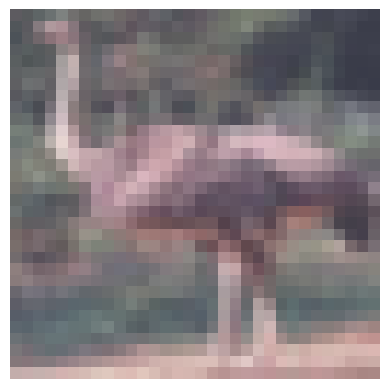

Top 16 Nearest Neighbors (in latent space)


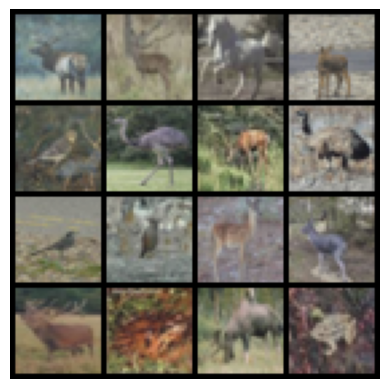

Image 2


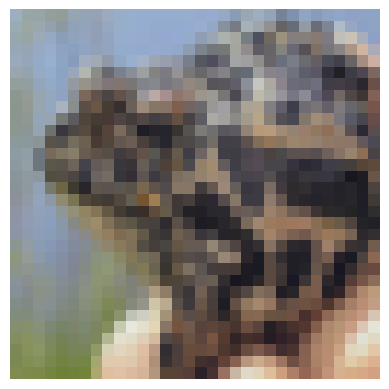

Top 16 Nearest Neighbors (in latent space)


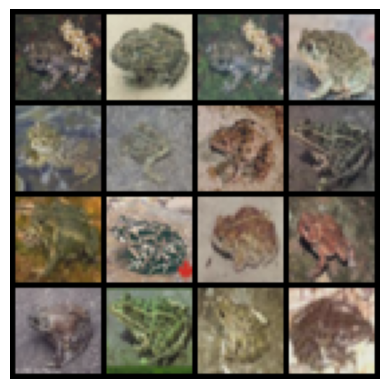

Image 3


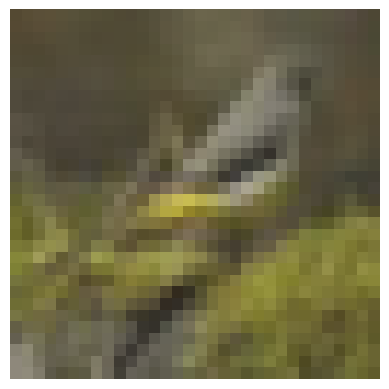

Top 16 Nearest Neighbors (in latent space)


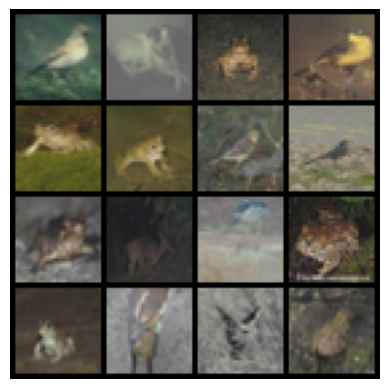

Image 4


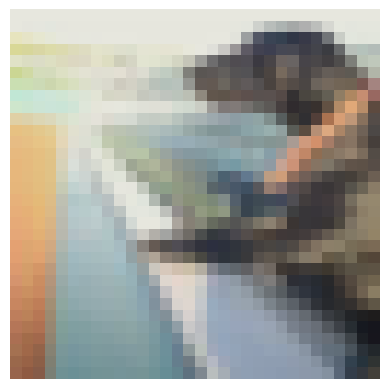

Top 16 Nearest Neighbors (in latent space)


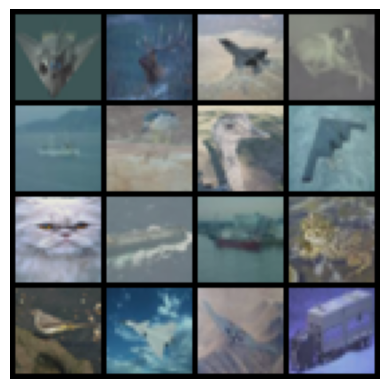

In [ ]:
display_nearest_neighbors('rotation', model, test_loader)

## Demo 3: SimCLR [[3]](https://arxiv.org/abs/2002.05709)

SimCLR is a contrastive learning framework to learn strong visual representations. An image $x$ is processed using data augmentation to produce two variants $x_i$ and $x_j$ which are both fed into encoder $f$ (a CNN) and projection head $g$ (a small MLP). The models optimize a contrastive loss to maximally align projected latents $z_i, z_j$. We consider $x_i, x_j$ as a positive pair, and any other $x_i, x_k$ pairs (i.e. different images in the same batch) are negative pairs. A visual diagram of the training procedure is shown below (from the paper).

![](https://drive.google.com/uc?id=1XW1uIkUTMSa0DZncivSYXzM5gA5FIhF6)

More formally, the loss between positive example $z_i, z_j$ is:
$$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = z_i^Tz_j / (\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert)$. The loss function can also be interpreted as a standard cross entropy loss to classify positive samples where logits are constructed using a given similarity function.

Note: A common idea in contrastive learning methods is that a larger batch means more negative samples. Therefore, these methods usually benefit the most from large-batch learning compared to other self-supervised learning tasks.

### Example Code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deepul_helper.resnet import resnet_v1
from deepul_helper.batch_norm import SyncBatchNorm, BatchNorm1d

# Some code adapted from https://github.com/sthalles/SimCLR
class SimCLR(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes, dist=None):
        super().__init__()
        self.temperature = 0.5
        self.projection_dim = 128

        if dataset == 'cifar10':
            resnet = resnet_v1((3, 32, 32), 50, 1, cifar_stem=True)
            resnet = SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048
        elif 'imagenet' in dataset:
            resnet = resnet_v1((3, 128, 128), 50, 1, cifar_stem=False)
            if dist is not None:
                resnet = nn.SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim, center=False)
        )

        self.dataset = dataset
        self.n_classes = n_classes
        self.dist = dist

    def construct_classifier(self):
        return nn.Sequential(nn.Linear(self.latent_dim, self.n_classes))

    def forward(self, images):
        n = images[0].shape[0]
        xi, xj = images
        hi, hj = self.encode(xi), self.encode(xj) # (N, latent_dim)
        zi, zj = self.proj(hi), self.proj(hj) # (N, projection_dim)
        zi, zj = F.normalize(zi), F.normalize(zj)

        # Each training example has 2N - 2 negative samples
        # 2N total samples, but exclude the current and positive sample

        if self.dist is None:
            zis = [zi]
            zjs = [zj]
        else:
            zis = [torch.zeros_like(zi) for _ in range(self.dist.get_world_size())]
            zjs = [torch.zeros_like(zj) for _ in range(self.dist.get_world_size())]

            self.dist.all_gather(zis, zi)
            self.dist.all_gather(zjs, zj)

        z1 = torch.cat((zi, zj), dim=0) # (2N, projection_dim)
        z2 = torch.cat(zis + zjs, dim=0) # (2N * n_gpus, projection_dim)

        sim_matrix = torch.mm(z1, z2.t()) # (2N, 2N * n_gpus)
        sim_matrix = sim_matrix / self.temperature
        # Mask out same-sample terms
        n_gpus = 1 if self.dist is None else self.dist.get_world_size()
        rank = 0 if self.dist is None else self.dist.get_rank()
        sim_matrix[torch.arange(n), torch.arange(rank*n, (rank+1)*n)]  = -float('inf')
        sim_matrix[torch.arange(n, 2*n), torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n)] = -float('inf')

        targets = torch.cat((torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n),
                             torch.arange(rank*n, (rank+1)*n)), dim=0)
        targets = targets.to(sim_matrix.get_device()).long()

        loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
        loss = loss / n
        return dict(Loss=loss), hi

    def encode(self, images):
        return self.resnet(images[0])

    def get_features(self, images):
        return self.resnet.get_features(images)


### Linear Classification
We can use the encoded vector $h_i$ as our latent representation.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('simclr')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 90.126, Top 5 Accuracy: 99.448

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


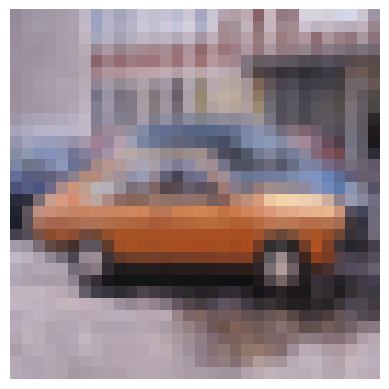

Top 16 Nearest Neighbors (in latent space)


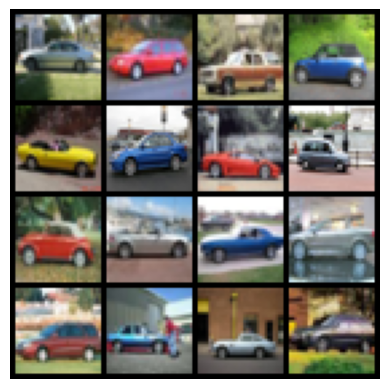

Image 2


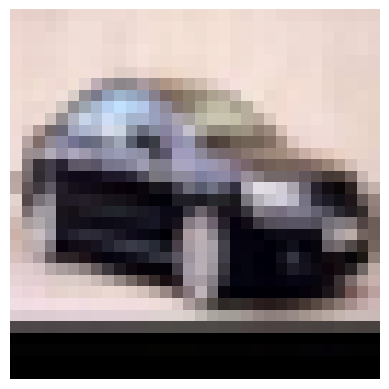

Top 16 Nearest Neighbors (in latent space)


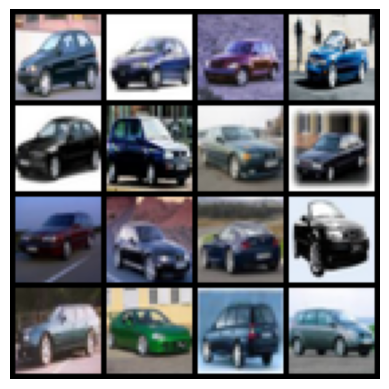

Image 3


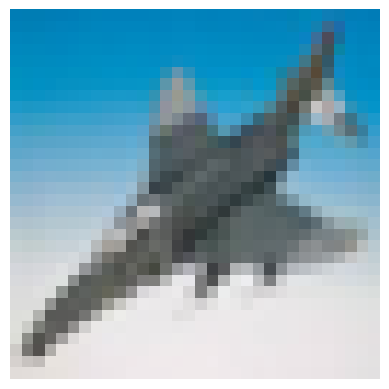

Top 16 Nearest Neighbors (in latent space)


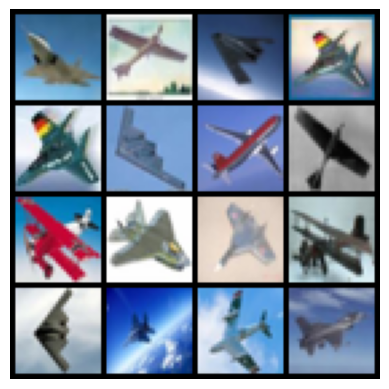

Image 4


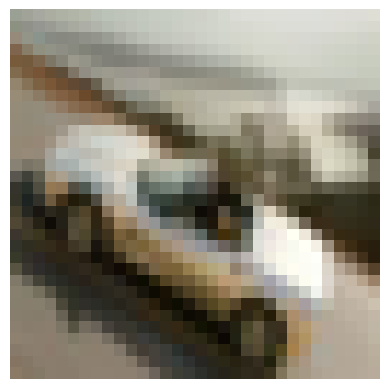

Top 16 Nearest Neighbors (in latent space)


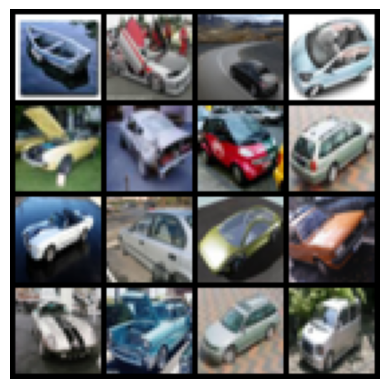

In [ ]:
display_nearest_neighbors('simclr', model, test_loader)

## Other Tasks
In addition to the above tasks, prior work has also investigated other self-superivsed tasks such as solving jigsaw puzzles [[4]](https://arxiv.org/abs/1603.09246), cycle-consistency [[5]](https://arxiv.org/abs/1903.07593), contrastive learning [[6]](https://arxiv.org/abs/1807.03748)[[7]](https://arxiv.org/abs/1905.09272)[[8]](https://arxiv.org/abs/1906.05849)[[9]](https://arxiv.org/abs/1911.05722), and patch prediction [[10]](https://arxiv.org/abs/1505.05192). See [here](https://github.com/jason718/awesome-self-supervised-learning) for a great resource on more self-supervised learning papers.

# Demo 4: Using Representations for Downstream Tasks

After pretraining a model on a self-supervised learning task, we can use it for other downstream tasks. In this demo, we use the pre-trained ResNet50 backbone from training SimCLR on a subset of ImageNet to learn a semantic segmentation model on Pascal VOC 2012. We use a simple U-Net [[11]](https://arxiv.org/abs/1505.04597) architecture with skip connections across feature maps between the SimCLR encoder and learned upsampling decoder. We do not fine-tune the SimCLR ResNet50 backbone, and only optimize the upsampling portion.

![](https://drive.google.com/uc?id=19dxxcwof0IA0jyv0VCl4rnZZf3ajA22s)

The training script can be found in `train_segmentation.py` [here](https://github.com/wilson1yan/cs294-158-ssl/blob/master/train_segmentation.py).

## Example Code

In [ ]:
# Code adapted from https://github.com/qubvel/segmentation_models.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.resnet import NormReLU

class SegmentationModel(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, n_classes):
        super().__init__()

        decoder_channels = (512, 256, 128, 64, 32)
        encoder_channels = (2048, 1024, 512, 256, 64) # Starting from head (resnet 50)

        # Construct decoder blocks
        in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.dec_blocks = nn.ModuleList(blocks)

        # Segmentation head for output prediction
        self.seg_head = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=3, padding=1)

    def forward(self, features, targets):
        features = features[1:] # remove first skip with same spatial resolution
        features = features[::-1] # reverse channels to start from head of encoder

        skips = features[1:]
        x = features[0]
        for i, decoder_block in enumerate(self.dec_blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        logits = self.seg_head(x)
        loss = F.cross_entropy(logits, targets)

        return dict(Loss=loss), logits


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels,
                      kernel_size=3, padding=1),
            NormReLU((out_channels, None, None)), # only care about channel dim for BN
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            NormReLU((out_channels, None, None))
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

## Segmentation Results
Below, we show a random subset of segmentations from the trained model. Every set of 3 images consists of the original image, the labeled segmentation, and the predicted segmentation.

Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012
Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012


/content/cs294-158-ssl/deepul_helper/demos.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(osp.join('results', 'imagenet100_simclr', 'seg_model_best.

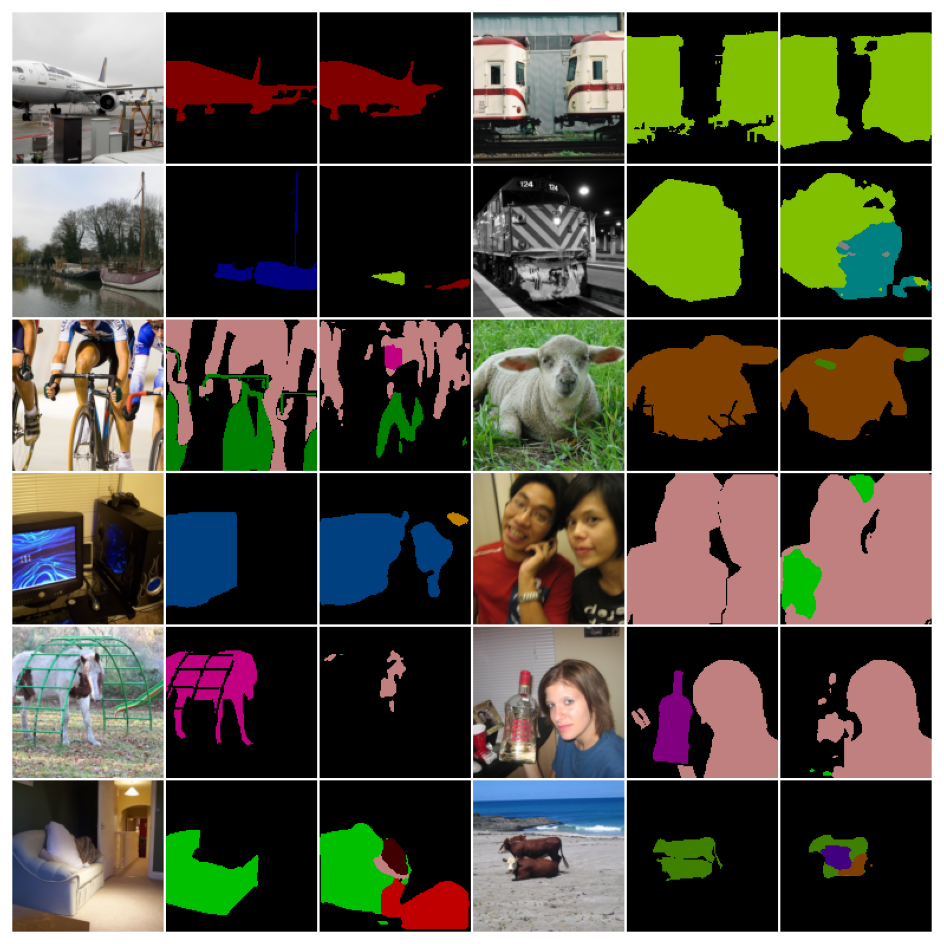

In [ ]:
from deepul_helper.demos import show_segmentation
show_segmentation()

# Demo 5: Avoiding Trivial Representations in Self-Supervised Tasks

When designing a self-supervised learning task, it is important to make sure that no trivial solutions exists. In general, a learned solution is trivial if the model is able to successfully complete its task by taking advantage of low-level features. As a result, it doesn't learn a good representation so downstream performance is bad.

For example, in the jigsaw [[4]](https://arxiv.org/abs/1603.09246) task, a model can "cheat" by just looking at the boundary textures of the jigsaw pieces, or following and matching straight lines across different pieces. These issues can generally be fixed by ranndom cropping, shifting, and spacially jittering.

We look at two other less obvious aspects of images that may reduce performance.

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point.
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

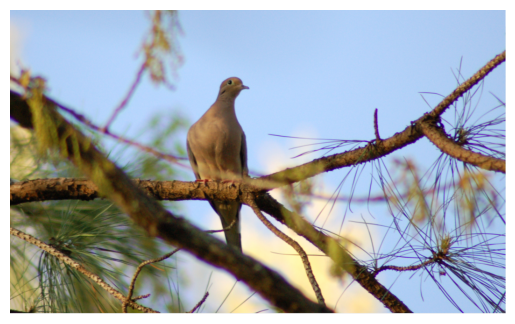

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# You can see some chromatic aberration in the purple fringes around the branches

image = Image.open('sample_images/chrom_ab_demo.png')
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

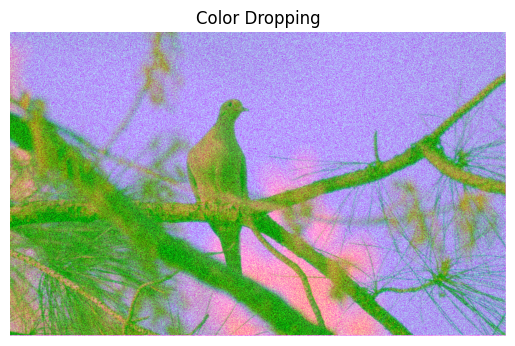

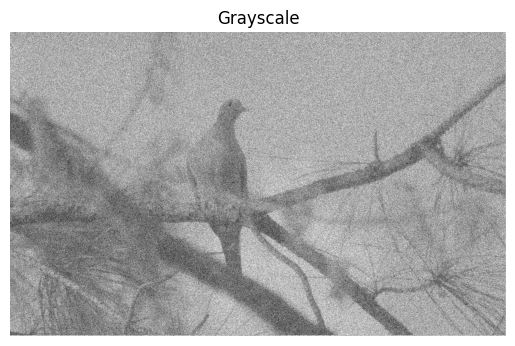

In [ ]:
import numpy as np

# Color Dropping
# We will drop all channels except R
image_cpy = image.copy()
pixels = image_cpy.load()

arr = np.array(image_cpy)
std_R = np.std(arr[:, :, 0])
mean_G, mean_B = np.mean(arr[:, :, 1]), np.mean(arr[:, :, 2])

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j] # (R, G, B, A)
    R, A = p[0], p[3]
    G = int(np.random.randn() * std_R + mean_G)
    B = int(np.random.randn() * std_R + mean_B)
    pixels[i, j] = (R, G, p[2], p[3])

plt.figure()
plt.title('Color Dropping')
plt.axis('off')
plt.imshow(image_cpy)
plt.show()

# Grayscale
image_cpy2 = image.copy()
pixels2 = image_cpy2.load()

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j]
    G = int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2])
    pixels2[i, j] = (G, G, G, 255)

plt.figure()
plt.title('Grayscale')
plt.axis('off')
plt.imshow(image_cpy2)
plt.show()

## Color Intensity Histograms

In the SimCLR paper, the authors show that the histogram of color intensities of different patches within the same image have very similar histograms, which may degrade training by encouraging models to look at low-level (pixel intensity) features to solve self-supervised tasks that involve matching positive patches of the same image.

Below, we run a similar demo to what was demonstrated in the paper

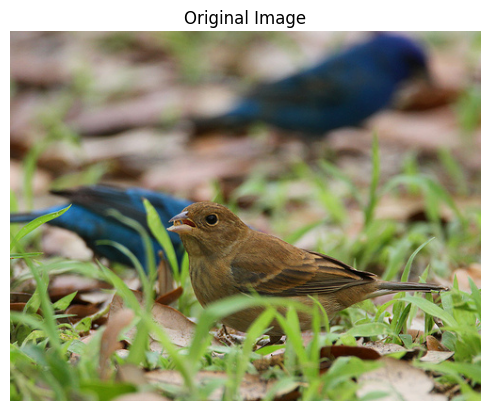

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

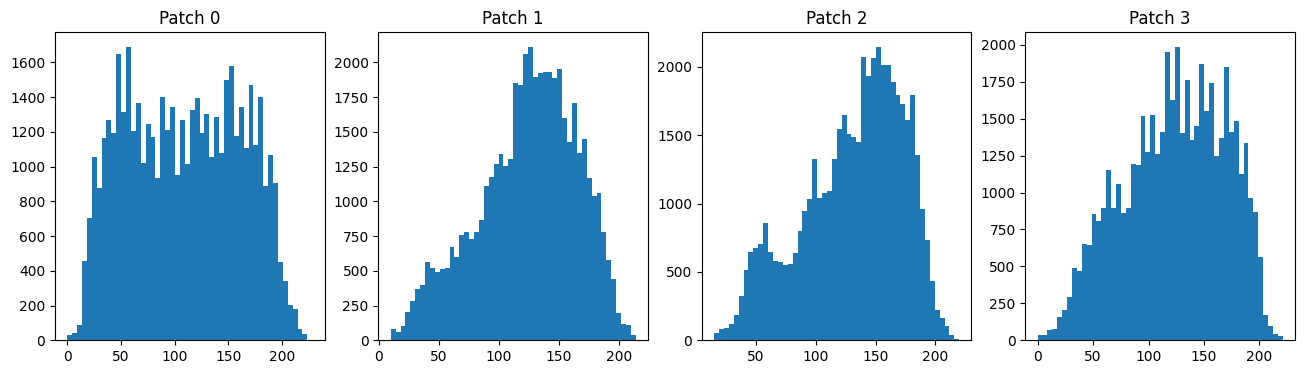

In [ ]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Now we apply color jittering to mitigate this effect

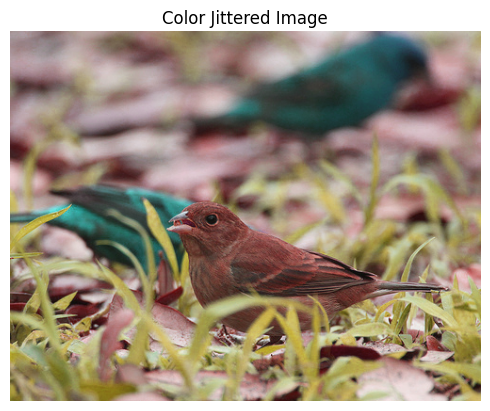

In [ ]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
jitter_img = color_jitter(image)

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

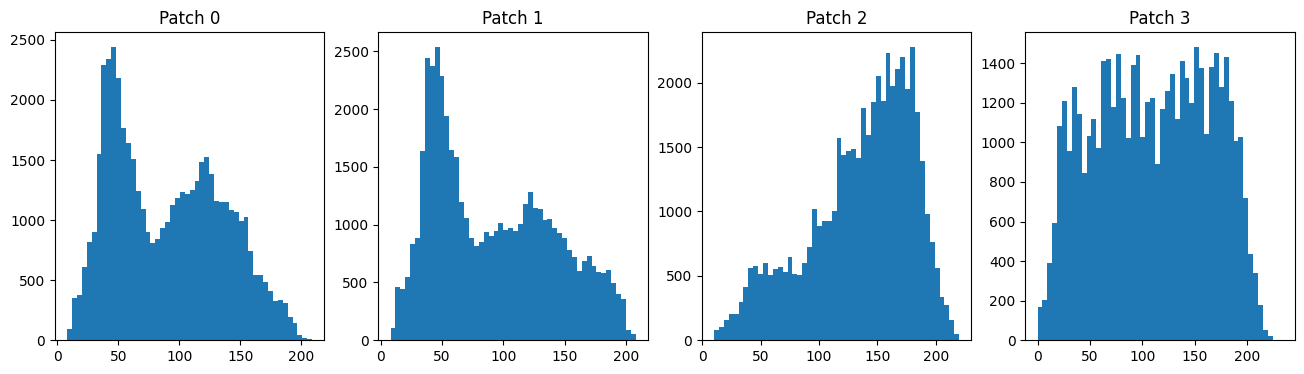

In [ ]:
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

In [ ]:
model1, linear_classifier1, train_loader1, test_loader1 = load_model_and_data('context_encoder')
train_acc1_1, train_acc5_1 = evaluate_classifier(model1, linear_classifier1, train_loader1)
test_acc1_1, test_acc5_1 = evaluate_classifier(model1, linear_classifier1, test_loader1)

100%|██████████| 170M/170M [00:03<00:00, 49.8MB/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


/content/cs294-158-ssl/deepul_helper/demos.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_pth, map_location='cpu')


In [ ]:
model2, linear_classifier2, train_loader2, test_loader2 = load_model_and_data('rotation')
train_acc2_2, train_acc5_2 = evaluate_classifier(model2, linear_classifier2, train_loader2)
test_acc2_2, test_acc5_2 = evaluate_classifier(model2, linear_classifier2, test_loader2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model3, linear_classifier3, train_loader3, test_loader3 = load_model_and_data('simclr')
train_acc3_3, train_acc5_3 = evaluate_classifier(model3, linear_classifier3, train_loader3)
test_acc3_3, test_acc5_3 = evaluate_classifier(model3, linear_classifier3, test_loader3)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import pandas as pd

results = [
    {"Model": "ContextEncoder", "Train Top-1": train_acc1_1, "Train Top-5": train_acc5_1, "Test Top-1": test_acc1_1, "Test Top-5": test_acc5_1},
    {"Model": "RotationPrediction", "Train Top-1": train_acc2_2, "Train Top-5": train_acc5_2, "Test Top-1": test_acc2_2, "Test Top-5": test_acc5_2},
    {"Model": "SimCLR", "Train Top-1": train_acc3_3, "Train Top-5": train_acc5_3, "Test Top-1": test_acc3_3, "Test Top-5": test_acc5_3},
]

df = pd.DataFrame(results)
print(df)

                Model  Train Top-1  Train Top-5  Test Top-1  Test Top-5
0      ContextEncoder       53.236       94.094       45.77       90.29
1  RotationPrediction       79.550       99.166       79.91       99.12
2              SimCLR       90.114       99.460       92.84       99.86


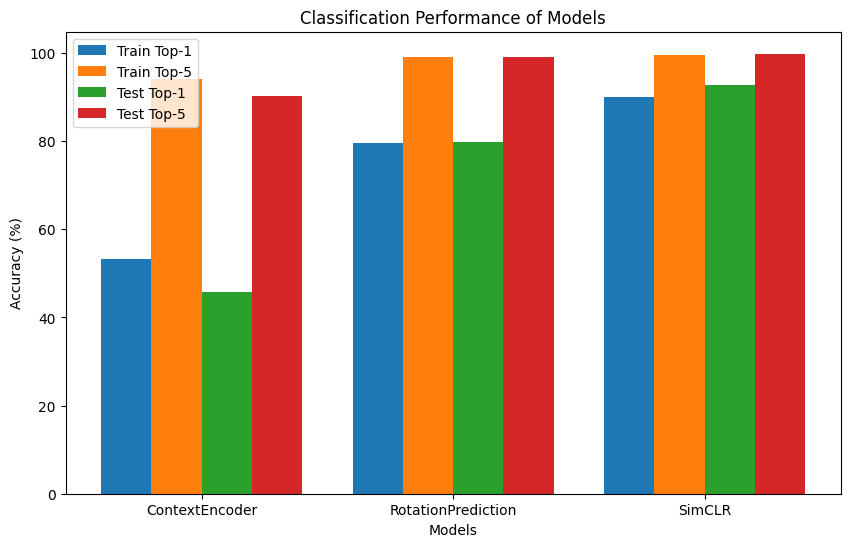

In [ ]:
import pandas as pd

results = [
    {"Model": "ContextEncoder", "Train Top-1": train_acc1_1, "Train Top-5": train_acc5_1, "Test Top-1": test_acc1_1, "Test Top-5": test_acc5_1},
    {"Model": "RotationPrediction", "Train Top-1": train_acc2_2, "Train Top-5": train_acc5_2, "Test Top-1": test_acc2_2, "Test Top-5": test_acc5_2},
    {"Model": "SimCLR", "Train Top-1": train_acc3_3, "Train Top-5": train_acc5_3, "Test Top-1": test_acc3_3, "Test Top-5": test_acc5_3},
]

df = pd.DataFrame(results)
print(df)

import matplotlib.pyplot as plt
import numpy as np

models = [result["Model"] for result in results]
train_top1 = [result["Train Top-1"] for result in results]
train_top5 = [result["Train Top-5"] for result in results]
test_top1 = [result["Test Top-1"] for result in results]
test_top5 = [result["Test Top-5"] for result in results]

x = np.arange(len(models))
width = 0.2


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width*1.5, train_top1, width, label="Train Top-1")
ax.bar(x - width*0.5, train_top5, width, label="Train Top-5")
ax.bar(x + width*0.5, test_top1, width, label="Test Top-1")
ax.bar(x + width*1.5, test_top5, width, label="Test Top-5")

ax.set_xlabel("Models")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Classification Performance of Models")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [1]:
from torchvision import datasets
from torchvision import transforms
import os.path as osp
import torch.utils.data as data
from deepul_helper.data import get_transform,get_datasets
from deepul_helper.utils import accuracy, unnormalize, remove_module_state_dict, seg_idxs_to_color
import torch

def load_data_mnist(task, dataset='fashionmnist'):
    train_dset, test_dset, n_classes = get_datasets(dataset, task)
    train_loader = data.DataLoader(train_dset, batch_size=128, num_workers=4,
                                   pin_memory=True, shuffle=True)
    test_loader = data.DataLoader(test_dset, batch_size=128, num_workers=4,
                                  pin_memory=True, shuffle=True)

    if dataset == "fashionmnist":
        dataset = "cifar10"
    ckpt_pth = osp.join('results', f'{dataset}_{task}', 'model_best.pth.tar')

    ckpt_pth = osp.join('results', f'cifar10_{task}', 'model_best.pth.tar')
    ckpt = torch.load(ckpt_pth, map_location='cpu')

    return train_loader, test_loader

In [2]:
from deepul_helper.demos import load_model_and_data, evaluate_accuracy, display_nearest_neighbors, show_context_encoder_inpainting,evaluate_classifier

%matplotlib inline
train_loader_mnist_1, test_loader_mnist_1 = load_data_mnist('context_encoder',dataset="fashionmnist")
train_acc1_mnist_1, train_acc5_mnist_1 = evaluate_classifier(model1, linear_classifier1, train_loader_mnist_1)
test_acc1_mnist_1, test_acc5_mnist_1 = evaluate_classifier(model1, linear_classifier1, test_loader_mnist_1)

get_transform(fashionmnist, context_encoder, True)


100.0%


Extracting data/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/fashionmnist/FashionMNIST/raw


100.0%


Extracting data/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/fashionmnist/FashionMNIST/raw




18.5%

100.0%
100.0%


Extracting data/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/fashionmnist/FashionMNIST/raw

Extracting data/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/fashionmnist/FashionMNIST/raw

get_transform(fashionmnist, context_encoder, False)


/var/folders/70/nn30stnd5pv6qccp5tx355m80000gn/T/ipykernel_20744/2467785868.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_pth, map_location='cp

FileNotFoundError: [Errno 2] No such file or directory: 'results/cifar10_context_encoder/model_best.pth.tar'

In [ ]:
train_loader_mnist_3, test_loader_mnist_3 = load_data_mnist('simclr',dataset="fashionmnist")
train_acc3_mnist_3, train_acc5_mnist_3 = evaluate_classifier(model3, linear_classifier3, train_loader_mnist_3)
test_acc3_mnist_3, test_acc5_mnist_3 = evaluate_classifier(model3, linear_classifier3, test_loader_mnist_3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-48-cfbb83b2a48c>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

In [ ]:
# Model 2
train_loader_mnist_2, test_loader_mnist_2 = load_data_mnist('rotation',dataset="fashionmnist")
train_acc2_mnist_2, train_acc5_mnist_2 = evaluate_classifier(model2, linear_classifier2, train_loader_mnist_2)
test_acc2_mnist_2, test_acc5_mnist_2 = evaluate_classifier(model2, linear_classifier2, test_loader_mnist_2)

<ipython-input-52-389a22c6c828>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_pth, map_location='cpu')


RuntimeError: running_mean should contain 9408 elements not 12288

            Model  Train Top-1  Train Top-5  Test Top-1  Test Top-5
0  ContextEncoder     9.125000    42.388333        8.81       41.57
1          SimCLR    11.336667    51.110000        8.51       45.83


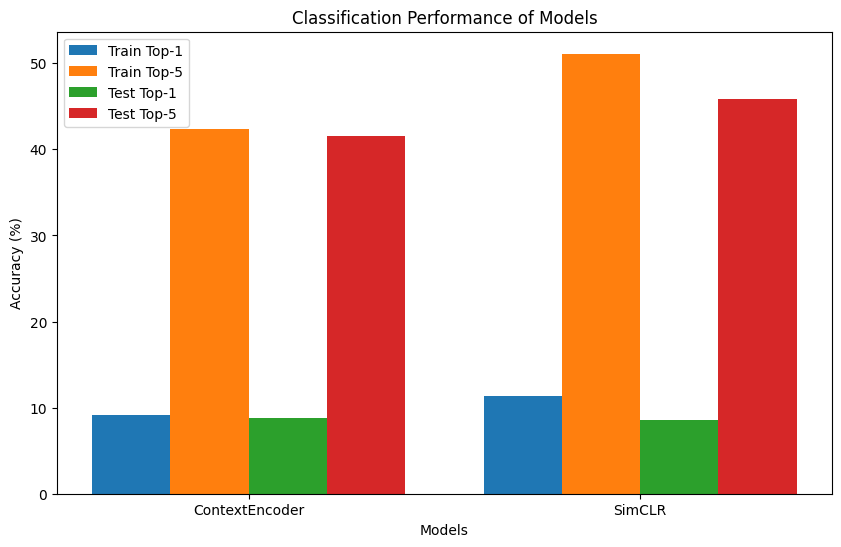

In [ ]:
import pandas as pd

results = [
    {"Model": "ContextEncoder", "Train Top-1": train_acc1_mnist_1, "Train Top-5": train_acc5_mnist_1, "Test Top-1": test_acc1_mnist_1, "Test Top-5": test_acc5_mnist_1},
    # {"Model": "RotationPrediction", "Train Top-1": train_acc2_mnist_2, "Train Top-5": train_acc5_mnist_2, "Test Top-1": test_acc2_mnist_2, "Test Top-5": test_acc5_mnist_2},
    {"Model": "SimCLR", "Train Top-1": train_acc3_mnist_3, "Train Top-5": train_acc5_mnist_3, "Test Top-1": test_acc3_mnist_3, "Test Top-5": test_acc5_mnist_3},
]

df = pd.DataFrame(results)
print(df)

import matplotlib.pyplot as plt
import numpy as np

models = [result["Model"] for result in results]
train_top1 = [result["Train Top-1"] for result in results]
train_top5 = [result["Train Top-5"] for result in results]
test_top1 = [result["Test Top-1"] for result in results]
test_top5 = [result["Test Top-5"] for result in results]

x = np.arange(len(models))
width = 0.2


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width*1.5, train_top1, width, label="Train Top-1")
ax.bar(x - width*0.5, train_top5, width, label="Train Top-5")
ax.bar(x + width*0.5, test_top1, width, label="Test Top-1")
ax.bar(x + width*1.5, test_top5, width, label="Test Top-5")

ax.set_xlabel("Models")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Classification Performance of Models")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

# Training

In [ ]:
# prompt: add drive

from google.colab import drive
drive.mount('/content/drive')

In [17]:
!unzip cs294-158-ssl-master.zip > /dev/null

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
unzip:  cannot find or open cs294-158-ssl-master.zip, cs294-158-ssl-master.zip.zip or cs294-158-ssl-master.zip.ZIP.


In [18]:
cd /content/cs294-158-ssl-master/

[Errno 2] No such file or directory: '/content/cs294-158-ssl-master/'
/content/cs294-158-ssl-master


In [19]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [3]:
!pip install matplotlib torch torchvision scikit-image opencv-python requests torchvision torchaudio git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-qy4s4eq_


Loading model for puzzle on pascalvoc2012
get_transform(pascalvoc2012, puzzle, True)
Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012
get_transform(pascalvoc2012, puzzle, False)
Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012


6it [01:10, 11.82s/it]
6it [01:12, 12.14s/it]


Validation Progress: Total: 1449, Correct: 174
Validation Accuracy: 12.01%
Epoch [1/50], Train Loss: 2.0667, Val Loss: 2.0953, Time: 2.40 min


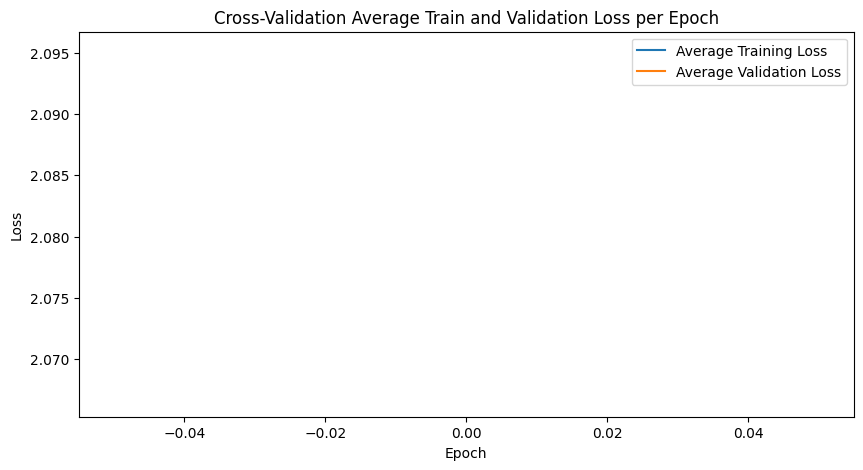

6it [01:13, 12.23s/it]
6it [01:09, 11.59s/it]                       

Validation Progress: Total: 1449, Correct: 188
Validation Accuracy: 12.97%
Epoch [2/50], Train Loss: 2.0287, Val Loss: 2.2129, Time: 2.39 min



6it [01:12, 12.12s/it]
6it [01:09, 11.62s/it]                       

Validation Progress: Total: 1449, Correct: 264
Validation Accuracy: 18.22%
Epoch [3/50], Train Loss: 1.9958, Val Loss: 2.0481, Time: 2.38 min



6it [01:10, 11.80s/it]
6it [01:11, 11.85s/it]

Validation Progress: Total: 1449, Correct: 361
Validation Accuracy: 24.91%
Epoch [4/50], Train Loss: 1.9420, Val Loss: 1.9349, Time: 2.37 min



6it [01:11, 11.98s/it]
6it [01:10, 11.70s/it]                       

Validation Progress: Total: 1449, Correct: 373
Validation Accuracy: 25.74%
Epoch [5/50], Train Loss: 1.8998, Val Loss: 1.9090, Time: 2.37 min



6it [01:11, 11.92s/it]
6it [01:10, 11.69s/it]                       


Validation Progress: Total: 1449, Correct: 357
Validation Accuracy: 24.64%
Epoch [6/50], Train Loss: 1.8635, Val Loss: 1.8943, Time: 2.37 min


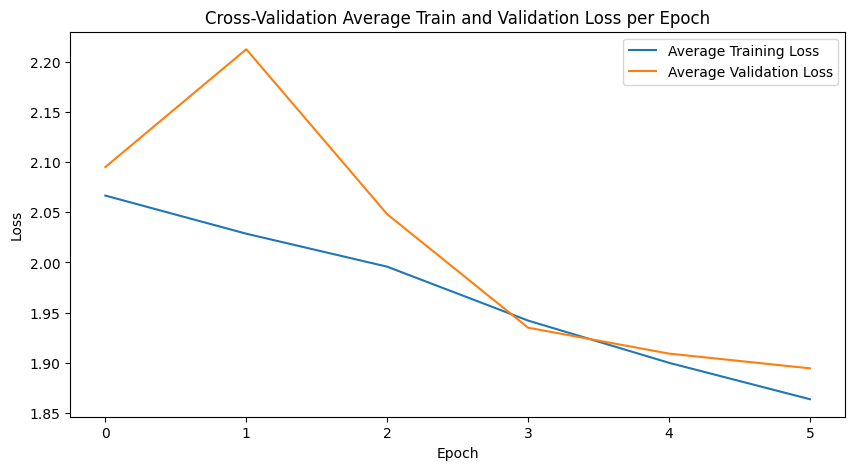

6it [01:14, 12.34s/it]
6it [01:10, 11.69s/it]                       

Validation Progress: Total: 1449, Correct: 349
Validation Accuracy: 24.09%
Epoch [7/50], Train Loss: 1.8491, Val Loss: 1.9190, Time: 2.41 min



6it [01:13, 12.23s/it]
6it [01:11, 11.99s/it]                       

Validation Progress: Total: 1449, Correct: 366
Validation Accuracy: 25.26%
Epoch [8/50], Train Loss: 1.8140, Val Loss: 1.9176, Time: 2.43 min



6it [01:12, 12.03s/it]
6it [01:11, 11.98s/it]

Validation Progress: Total: 1449, Correct: 394
Validation Accuracy: 27.19%
Epoch [9/50], Train Loss: 1.7800, Val Loss: 1.8759, Time: 2.41 min



 80%|████████  | 4/5 [01:00<00:15, 15.23s/it]


KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm
import importlib
import deepul_helper  # Replace with your actual module name
%matplotlib inline

importlib.reload(deepul_helper)
from deepul_helper.demos import load_model_and_data

# Define hyperparameters and configurations
num_epochs = 50
batch_size = 256
learning_rate = 0.001
classifier_lr = 0.001  # Separate learning rate for the classifier
patch_dim = (3, 3)
gap = 16
subset_data = 'pascalvoc2012'

# Initialize model, linear classifier, optimizer, criterion, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, linear_classifier, train_loader, test_loader = load_model_and_data('puzzle', dataset=subset_data, batch_size=batch_size)
model = model.to(device)
linear_classifier = linear_classifier.to(device)

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifier_optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=classifier_lr)
criterion = torch.nn.CrossEntropyLoss()

# Scheduler for model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Loss trackers
global_trn_loss = []
global_val_loss = []

# Training and Validation Loop
for epoch in range(num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()

    # Training loop
    model.train()
    linear_classifier.train()
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_loader.dataset) / batch_size)):
        uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)

        # Zero the gradients
        optimizer.zero_grad()
        classifier_optimizer.zero_grad()

        # Forward pass for the model
        output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch, random_patch_label)
        task_loss = criterion(output, random_patch_label)  # Loss for the SSL task

        # Forward pass for the linear classifier
        classifier_output = linear_classifier(output_fc6_uniform)
        classifier_loss = criterion(classifier_output, random_patch_label)  # Loss for classifier

        # Total loss and backward
        total_loss = task_loss + classifier_loss
        total_loss.backward()

        # Optimizer steps
        optimizer.step()
        classifier_optimizer.step()

        # Track training loss
        train_running_loss.append(total_loss.item())

    # Validation loop
    correct = 0
    total = 0
    model.eval()
    linear_classifier.eval()
    with torch.no_grad():
        for idx, data in tqdm(enumerate(test_loader), total=int(len(test_loader.dataset) / batch_size)):
            uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)

            # Model forward
            output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch, random_patch_label)
            task_loss = criterion(output, random_patch_label)

            # Linear classifier forward
            classifier_output = linear_classifier(output_fc6_uniform)
            classifier_loss = criterion(classifier_output, random_patch_label)

            # Validation loss
            total_loss = task_loss + classifier_loss
            val_running_loss.append(total_loss.item())

            # Calculate accuracy
            _, predicted = torch.max(classifier_output.data, 1)
            total += random_patch_label.size(0)
            correct += (predicted == random_patch_label).sum().item()

        val_accuracy = 100 * correct / total
        print(f'Validation Progress: Total: {total}, Correct: {correct}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # Average losses
    avg_train_loss = sum(train_running_loss) / len(train_running_loss)
    avg_val_loss = sum(val_running_loss) / len(val_running_loss)
    global_trn_loss.append(avg_train_loss)
    global_val_loss.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    # Epoch summary
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Time: {(time.time() - start_time) / 60:.2f} min')

    # Save model checkpoint every 20 epochs
    if epoch % 5 == 0:
        MODEL_SAVE_PATH = f'/content/drive/MyDrive/Model Patches/model_{batch_size}_{num_epochs}_{learning_rate}_{subset_data}_{patch_dim[0]}_{gap}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'classifier_state_dict': linear_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'classifier_optimizer_state_dict': classifier_optimizer.state_dict(),
            'loss': total_loss,
            'global_trn_loss': global_trn_loss,
            'global_val_loss': global_val_loss
        }, MODEL_SAVE_PATH)

        # Plotting training and validation losses
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(epoch + 1)], global_trn_loss, label="Average Training Loss")
        plt.plot([i for i in range(epoch + 1)], global_val_loss, label="Average Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss per Epoch")
        plt.legend()
        plt.show()